# Predicting physical stress is one of the most important factors in the development of fitness wearables. In this paper, I present a research project aimed at predicting physical stress using wearable technology data and machine learning classification techniques. A traditional Logistic Regression model, a Random Forest, an XGBoost classifier, a Histogram Gradient Boosting classification, and a Multi-Layer Perceptron model were used in the research. Specificity and negative predictive value was used to compare models, with Random Forest and XGBoost emerging as very strong models for this task. The most significant feature in predicting physical stress was temperature. The findings from this research could be applied to other health-focused fields or issues, such as classification of rare disease. Given the subject demographic of this dataset was majority male, repeating this comparison research on a demographic with even gender proportions would be valuable, though the lack of female inclusion in health datasets could pose an issue in this future research step.

# Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning) 
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', message = "Pandas requires version .* or newer of 'bottleneck'.*", category=UserWarning)
warnings.filterwarnings("ignore", message="Pandas requires version")
warnings.filterwarnings("ignore", message="Setting penalty=None will ignore the C")
from imblearn.combine import SMOTETomek
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, recall_score,average_precision_score, precision_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve 
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
import seaborn as sns
import pickle 

from sklearn.metrics import ConfusionMatrixDisplay
random_seed = 42

# data processing

In [2]:


for file in os.listdir():
    if file.endswith(".dat"):
        record = wfdb.rdrecord(file[:-4], sampfrom=0, sampto=None)
        signals = record.p_signal
        raw_signals = record.d_signal
        signal_names = record.sig_name
        df = pd.DataFrame(data = signals, columns=record.sig_name)
        df['time'] = np.arange(len(df)) / record.fs
        # print(df.head())
        df.to_csv(file[:-4] + ".csv", index=False)



In [3]:
# EDA for plots of raw signals here

In [4]:
for file in os.listdir():
    if file.endswith('_SpO2HR.csv'):
        df = pd.read_csv(file)
        # print(df.head())
        df.drop(columns = ['time'], inplace=True)
        sync_df=pd.DataFrame(np.repeat(df.values, 8, axis=0), columns=df.columns)
        sync_df['time'] = np.arange(len(sync_df)) / 8
        sync_df.to_csv(file[:-4] + "_sync.csv", index=False)


In [5]:
for file in os.listdir():
    # for each subject, read in the sync file and the acc file

    for i in range(1,21):
        if file.startswith("Subject" + str(i)) and file.endswith("_sync.csv"):

            # read file in
            sync_df = pd.read_csv(file)

            # add other dataframe to sync df
            for other_file in os.listdir():
                if other_file.startswith("Subject" + str(i)) and other_file.endswith("AccTempEDA.csv"):
                    acc_df = pd.read_csv(other_file)

                    # merge dataframes
                    merged_df = pd.merge(sync_df, acc_df, how='inner', on='time')

                    # add physiological stress column
                    ## need the seconds for the physiological stress column -- each entry is 1/8 of a second, so need entries between 5 minutes and 10 minutes -- 5*60*8 for the start of the 5 minutes, then need 5 minutes after that so 10*60*8 is when the 5 minutes ends
                    merged_df['physiological_stress'] = np.where((merged_df['time'] >= 5*60*8) & (merged_df['time'] <= 10*60*8), 1, 0)
                    
                    # save merged dataframe
                    merged_df.to_csv("Subject" + str(i) + "_merged.csv", index=False)



# missing data

In [6]:
# checking for missing data in each file
for file in os.listdir():
    for i in range(1,21):
        if file.startswith("Subject" + str(i)+ "_merged.csv"):
            
            # reading in file
            df = pd.read_csv(file)

            # check data for missing values - should be no missing values throughout
            print(f'{file} has missing values: {df.isnull().values.any()}')
           
            # no missing values!

Subject2_merged.csv has missing values: False
Subject17_merged.csv has missing values: False
Subject20_merged.csv has missing values: False
Subject12_merged.csv has missing values: False
Subject7_merged.csv has missing values: False
Subject18_merged.csv has missing values: False
Subject15_merged.csv has missing values: False
Subject8_merged.csv has missing values: False
Subject10_merged.csv has missing values: False
Subject5_merged.csv has missing values: False
Subject13_merged.csv has missing values: False
Subject6_merged.csv has missing values: False
Subject3_merged.csv has missing values: False
Subject16_merged.csv has missing values: False
Subject9_merged.csv has missing values: False
Subject11_merged.csv has missing values: False
Subject4_merged.csv has missing values: False
Subject19_merged.csv has missing values: False
Subject1_merged.csv has missing values: False
Subject14_merged.csv has missing values: False


# outlier detection

In [7]:
# referencing https://www.sciencedirect.com/science/article/pii/S2307187724000452 here for background research on time series outlier detection -- also detecting outliers within each subject because data is subject specific 

# using isolation forest for outlier detection because of strengths listed in paper and common implementation in machine learning

from sklearn.ensemble import IsolationForest

def detect_outliers_isolation_forest(df, contamination=.05, random_state = 42):
    """"
    Detects outliers in a dataframe using Isolation Forest
    Returns a list of the indices of the outliers
    df: the dataframe to detect outliers in
    contamination: the proportion of outliers in the data
    random_state: the random state to use for reproducibility
    """""

    # selecting numeric features then converting to a list of features to use for outlier detection
    features = df.select_dtypes(include=[np.number]).columns.tolist()

    # removing the physiological stress column because it won't be helpful in detecting outliers in the other features -- this column is binary and will not contribute to the outlier detection process
    if 'physiological_stress' in features:
        features.remove('physiological_stress')
    
    # initializing the Isolation Forest model with the specified contamination, random state, and other parameters
    clf = IsolationForest(contamination=contamination, random_state=random_state, n_estimators=100, max_samples='auto')

    # fitting the model to the data using the selected features
    outlier_labels = clf.fit_predict(df[features])

    # The fit_predict method returns 1 for inliers and -1 for outliers - creating a mask to identify outliers for the function
    outlier_mask = outlier_labels == -1

    # returning the outlier mask which is a boolean array indicating which rows are outliers
    return outlier_mask

# utilizing outlier detection func†ion
for file in os.listdir():
    for i in range(1,21):
        if file.startswith("Subject" + str(i)+ "_merged.csv"):

            # reading in the merged dataframe for the subject
            df = pd.read_csv(file)

            # checking for outliers using the Isolation Forest method
            outlier_mask = detect_outliers_isolation_forest(df, contamination=.10, random_state=42)
            
            # printing out the number of outliers detected in the dataframe
            n_outliers = sum(outlier_mask)
            print(f'{file} has {sum(outlier_mask)} outliers')
           
            # important to note that the outliers are not removed from the data frame and this step is more so focused on detecting outliers

            # expecting to have more outliers in this data because of variability in nature of physiological data and the fact that the data is subject specific


Subject2_merged.csv has 1833 outliers
Subject17_merged.csv has 1825 outliers
Subject20_merged.csv has 2017 outliers
Subject12_merged.csv has 1823 outliers
Subject7_merged.csv has 1818 outliers
Subject18_merged.csv has 1826 outliers
Subject15_merged.csv has 1819 outliers
Subject8_merged.csv has 1826 outliers
Subject10_merged.csv has 1824 outliers
Subject5_merged.csv has 1825 outliers
Subject13_merged.csv has 1824 outliers
Subject6_merged.csv has 1824 outliers
Subject3_merged.csv has 1826 outliers
Subject16_merged.csv has 1823 outliers
Subject9_merged.csv has 1825 outliers
Subject11_merged.csv has 2026 outliers
Subject4_merged.csv has 1825 outliers
Subject19_merged.csv has 1822 outliers
Subject1_merged.csv has 1824 outliers
Subject14_merged.csv has 1823 outliers


# sensor fusion

In [8]:
# sensor fusion focused on combining data across sensors to provide better accuracy than from just one data source

# while the data is all from one sensor in my case - the data from the Empatica wristaband - the data is still from multiple sensors (SpO2HR, Acc, Temp, EDA) and can be combined to provide a more accurate model

# sensor fusion is a little bit like feature engineering that I have used in other machine learning projects


# initializing a function for sensor fusion -- using a function so I can easily apply it to each subject's merged dataframe and perform the same operations on each one while also demonstrating when there are specific issues in my implementation

def sensor_fusion(df):
    """
    Combines data from multiple sensors into a single feature
    Returns a dataframe with the sensor fusion features
    df: the dataframe to perform sensor fusion on
    """
    fused_df = df.copy()

    # creating an acceleration magnitude feature - degree of physical activity
    
    # checking if there are any acceleration columns in the dataframe, which there should be
    actual_acc_columns = []

    # checking for acceleration columns in the dataframe - looking for columns that contain 'ax', 'ay', or 'az' in their names given these are my specific acceleration axes and corresponding column names
    for col in df.columns:
        if any(acc_axis in col.lower() for acc_axis in ['ax', 'ay', 'az']):
            actual_acc_columns.append(col)

    # checking to see if there are all three axes for acceleration data - if there are not all three axes, we cannot compute the magnitude
    if len(actual_acc_columns) >= 3:

        # sorting the actual acceleration columns to ensure they are in a consistent order for calculating the magnitude
        actual_acc_columns = sorted(actual_acc_columns)

        # calculating the magnitude of acceleration using the formula sqrt(ax^2 + ay^2 + az^2) - this is a common way to calculate the magnitude of a 3D vector
        fused_df['acc_magnitude'] = np.sqrt(df[actual_acc_columns[0]]**2 + df[actual_acc_columns[1]]**2 + df[actual_acc_columns[2]]**2)

    # creating activity adjusted heart rate feature because heart rate generally increases with increased physical activity, as measured by acceleration magnitude

    # checking if 'hr' column exists in the dataframe and if 'acc_magnitude' has been created
    if 'hr' in df.columns and 'acc_magnitude' in fused_df.columns:

        # adjusting heart rate by dividing it by (1 + acceleration magnitude) - this is a simple way to adjust heart rate based on physical activity
        fused_df['hr_activity_adjusted'] = fused_df['hr'] / (1 + fused_df['acc_magnitude'])
    
    # creating temperature to EDA ratio feature because body temperature generally increases with physical activity, and increased body temperature can be manifested physically through sweat which is measured by electro-dermal activity -- finding a ratio of body temperature to EDA can provide a measure of how much someone is sweating relative to their body temperature

    if 'temp' in df.columns and 'EDA' in df.columns:

        # creating a new feature that is the ratio of temperature to EDA - adding a small constant to EDA to avoid division by zero
        fused_df['temp_eda_ratio'] = fused_df['temp'] / (fused_df['EDA'] + .001)

    # returning the fused dataframe with the new features
    return fused_df

# iterating through each subject and applying the sensor fusion function to each subject's merged dataframe, then returning the fused dataframe to a new CSV file
for file in os.listdir():
    for i in range(1,21):
        if file.startswith("Subject" + str(i)+ "_merged.csv"):
            df = pd.read_csv(file)
            fused_df = sensor_fusion(df)
            fused_df.to_csv("Subject" + str(i) + "_merged_fused.csv", index=False)

# further feature engineering 

In [9]:
# initially decided to return to this after running my models to see if it would be necessary 

# given strength of models on initial features and sensor fused features, I do not think further feature engineering is necessary

# discretization

In [10]:
# will return back to this step to see if it is necessary to use discretization in the final model - discretization is the process of converting continuous data into discrete data, which can be useful for some models

# after running the models, I found that the models performed well without discretization - but this is something I can always return to in the future if needed

# feature selection

In [11]:
# using all features for now, will consider removing if some features are not useful and detract from in the final model as based on feature importance

# Given strength of models with all features, I do not think further feature engineering is necessary at this time

# feature extraction

In [12]:
# not necessary here because all data is numeric -- ie: data isn't image or text based so there aren't features to extract

# combining dataframes

In [13]:
# initially was using leave one subject out (LOSO) cross validation out because of individual data frames for each subject -- each subject is a different person and the data is subject specific, but given the computational requirements for LOSO and my computational restrictions for this project, I decided to switch to stratified K-fold cross-validation with instead

# stratified K-fold cross-validation is a method that ensures each fold has a representative sample of the data from each subject, which is important for generalizing the model to new subjects


# setting up the data for modeling - reading in all the fused dataframes and combining them into a single dataframe for modeling

# creating an empty list to store all the dataframes for each subject
all_subjects = []

# creating empty list to store subject_ids from each data frame
subject_ids = []

# iterating through each file in the current directory
for file in os.listdir():
    for i in range(1,21):
        if file.startswith(f"Subject{i}_merged_fused.csv"):
            df = pd.read_csv(file)

            # adding column for subject_id to keep track of which subject the data came from
            df['subject_id'] = i

            # appending the dataframe to the list of all subjects
            all_subjects.append(df)
            break

# checking if all_subjects list is not empty before concatenating
if all_subjects:

    # concatenating all the dataframes in the list into a single dataframe
    all_subjects_df = pd.concat(all_subjects, ignore_index=True)

# checking to see if the code worked correctly
    print(f"sucessfully combined {len(all_subjects)} dataframes into one")


sucessfully combined 20 dataframes into one


In [14]:
# examining balanced class distribution of the physiological stress column
all_subjects_df['physiological_stress'].value_counts()/all_subjects_df.shape[0]
# where 1 represents physiological stress and 0 represents no physiological stress... very unbalanced
# here there are minority class samples

physiological_stress
0    0.994517
1    0.005483
Name: count, dtype: float64

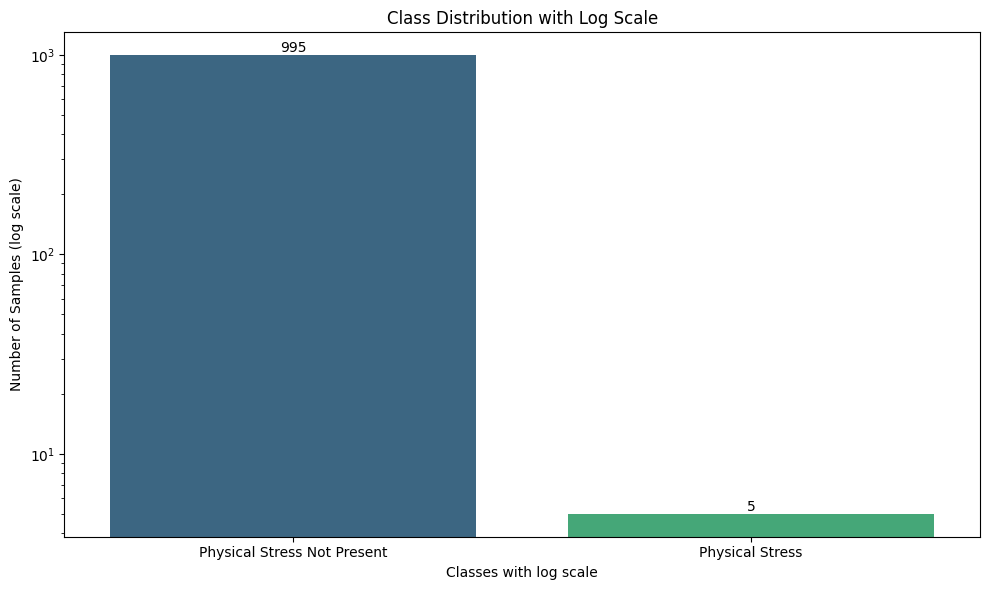

In [15]:
# difficult to visualize just how small this is -- going to use synthetic dataset and log scales for bar plot instead of plotting tiny values

from sklearn.datasets import make_classification

random_seed = random_seed

n_samples = 1000
n_majority = 995
n_minority = 5

# generating a synthetic dataset with a large class imbalance
x_majority, y_majority = make_classification(
    n_samples=n_majority, 
    n_features=2, 
    n_redundant=0, 
    n_clusters_per_class=1, 
    n_classes=1,  
    random_state=random_seed
)
y_majority = np.zeros(n_majority)  

x_minority, y_minority = make_classification(
    n_samples=n_minority, 
    n_features=2, 
    n_redundant=0, 
    n_clusters_per_class=1, 
    n_classes=1, 
    random_state=random_seed
)
y_minority = np.ones(n_minority)  

# combine the datasets
x = np.vstack((x_majority, x_minority))
y = np.hstack((y_majority, y_minority))

# plot 
df = pd.DataFrame(x, columns=['Physical Stress Not Present', 'Physical Stress'])
df['Classes'] = y

class_counts = df['Classes'].value_counts()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.yscale('log')
plt.xlabel('Classes with log scale')
plt.ylabel('Number of Samples (log scale)')
plt.title('Class Distribution with Log Scale')
plt.xticks([0,1], ['Physical Stress Not Present', 'Physical Stress'])
for i, v in enumerate(class_counts.values):
    ax.text(i, v, f'{v}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# hyperparameter tuning

In [16]:
def evaluate_model(X_train, y_train, X_test, y_test, model_name, model, use_smote=True, random_seed=42, use_weights=False):
    """
    Train and evaluate a single model
    
    Parameters:
    -----------
    X_train, y_train : Training data
    X_test, y_test : Test data
    model_name : Name of the model for reporting
    model : The model object to train
    use_smote : Whether to apply SMOTE
    use_weights: Whether to use class weights for imbalanced data
    random_seed : Random seed for reproducibility
    
    Returns:
    --------
    dict : Performance metrics and trained model
    """
    # Scale features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_final, y_train_final = X_train_scaled, y_train  # Default to original data

    # looking at minority/majority classes to find issues
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    minority_class = unique_classes[np.argmin(class_counts)]
    majority_class = unique_classes[np.argmax(class_counts)]
    imbalance_ratio = np.max(class_counts) / np.min(class_counts)
    print(f"Class imbalance ratio: {(imbalance_ratio):.2f}")

    # Apply SMOTE
    if use_smote == True and not use_weights:
        try:
            # Count samples in each class
            unique_classes, class_counts = np.unique(y_train, return_counts=True)
            min_samples = np.min(class_counts)
            
            # Only apply SMOTE if enough samples -- had issues here
            if min_samples > 5:
                smote = SMOTETomek(random_state=random_seed)
                # smote = SMOTE(
                #     random_state=random_seed, 
                #     k_neighbors=min(5, min_samples-1)
                # )
                X_train_final, y_train_final = smote.fit_resample(X_train_scaled, y_train)
                print(f"  After SMOTE - X_train: {X_train_final.shape}, y_train: {y_train_final.shape}")
        except Exception as e:
            print(f"  Error in SMOTE: {e}. Using original data.")
            X_train_final, y_train_final = X_train_scaled, y_train


    elif use_weights == True:
        try: 
            # balanced weights as number of samples/(number of classes * np.bincount(y))
            n_samples = len(y_train)
            class_weights = {}
            n_classes = len(unique_classes)

            for cls, count in zip(unique_classes, class_counts):
                if cls == minority_class:
                    # for minority class, double the weight to counteract imbalance + be more aggressive
                    class_weights[cls] = (n_samples / (n_classes * count))*2
                else:
                    class_weights[cls] = n_samples / (n_classes * count)
            
            print("Using class_weights:", class_weights)
           
            if model_name == "MLP Classifier":
                print( "  MLP Classifier does not support class weights directly. Using sample weights instead.")
            elif hasattr(model, 'class_weight'):
                model.class_weight = class_weights
                print(f"  Using class weights: {class_weights}")
            
            elif hasattr(model, 'set_params'):
                try: 
                    model.set_params(class_weight=class_weights)
                except Exception: 
                    print("  Model does not support class weights.")

                    # XGboost uses scale_pos_weight parameter
                    if model_name == "XGBoost" and len(unique_classes) == 2:
                        scale_pos_weight = imbalance_ratio 
                        model.set_params(scale_pos_weight=scale_pos_weight)
                        print(f"  Using scale_pos_weight={scale_pos_weight} for XGBoost.")
                    
                    # HGBC uses class_weights = 'balanced' for imbalanced data
                    elif model_name == 'Hist Gradient Boosting':
                        model.set_params(class_weight='balanced')
                        print("  Using class_weight='balanced' for Hist Gradient Boosting.")
      
       # Handle any exceptions in setting class weights
        except Exception as e:
            print(f"  Error calculating class weights: {e}. Using original data.")


    # Train given model on data
    try:
        print(f"  Training {model_name}...")

        threshold = .3 # to favor minority class
        model.fit(X_train_final, y_train_final)
        
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test_scaled)

            # Get index of positive class (1)
            pos_class_idx = np.where(model.classes_ == 1)[0][0]  
            y_pred_prob = y_prob[:, pos_class_idx]

            # Apply threshold to get binary predictions
            y_pred = (y_pred_prob >= threshold).astype(int)  
            
            # changing predictions to original class labels

            y_pred = np.where(y_pred == 1, minority_class, majority_class)
        else:
            # Predict and evaluate
            y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        accuracy = balanced_accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0.0
        npv = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0.0
        
        # other metrics but avoiding division by zero errors
        try: 
            recall = recall_score(y_test, y_pred, pos_label = minority_class)
        except:
            recall = 0.0
            print("  Warning: Recall calculation failed. Setting recall to 0.0.")
        
        try: 
            precision = precision_score(y_test, y_pred, pos_label=minority_class, zero_division=0)
        except:
            precision = 0.0
            print("  Warning: Precision calculation failed. Setting precision to 0.0.")
        
        try:
            f1 = f1_score(y_test, y_pred, pos_label=minority_class)
        except:
            f1 = 0.0
            print("  Warning: F1 score calculation failed. Setting F1 to 0.0.")

        y_test_binary = (y_test == minority_class).astype(int)

        # calculating roc and auc if possible

        roc_auc = None
        pr_auc = None

        if hasattr(model, 'predict_proba'):
            try:
                roc_auc = roc_auc_score(y_test_binary, y_prob[:, pos_class_idx])

                pr_auc = average_precision_score(y_test_binary, y_prob[:, pos_class_idx])

                print(f" {model_name} ROC AUC: {roc_auc:.4f}, {model_name} PR AUC: {pr_auc:.4f}")
            except Exception as e:
                print("Error calculating AUC metrics:{e}")
        else:
            print(f"{model_name} does not support ROC AUC or PR AUC calculation.")
        
        print(f"confusion matrix:\n{cm}")
                
        # Return results
        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'specificity': specificity,
            'npv': npv,
            'confusion_matrix': cm,
            'classification_report': classification_report(y_test, y_pred, output_dict=True),
            'model': model,
            'recall': recall
        }
    except Exception as e:
        print(f"  Error training {model_name}: {e}")
        return None

In [17]:
def plot_cm(all_results):
    max_fold = 0
    for model_name, results in all_results.items():
        if results:
            folds = [r.get('fold', 0) for r in results if isinstance(r, dict)]
            if folds:
                # Find the maximum fold number for each model
                model_max_fold = max(folds)
                if model_max_fold > max_fold:
                    max_fold = model_max_fold
    
    last_fold_results = {}
    for model_name, results in all_results.items():
        for result in results:
            if result.get('fold') == max_fold and 'confusion_matrix' in result:
                last_fold_results[model_name] = result
        
    n_models = len(last_fold_results)
    n_cols = min(3, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    axes = axes.flatten() if n_rows > 1 else [axes]

    for i, (model_name, result) in enumerate(last_fold_results.items()):

        if i < len(axes):
            if 'confusion_matrix' in result:
                cm = result['confusion_matrix']

                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot(ax=axes[i], cmap='Blues', values_format='d')
                axes[i].set_title(f"{model_name} - Test Fold")
                axes[i].set_xlabel('Predicted')
                axes[i].set_ylabel('True')
    for i in range(n_models, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

  

def plot_comparative_results(all_results, summary):
    """Plot comparative results of different models including PR-AUC"""
    # Create a figure with 6 subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    axes = axes.flatten()
    
    # Prepare data for all metrics
    model_names = []
    accuracy_data = []
    recall_data = []
    roc_auc_data = []
    pr_auc_data = []
    specificity_data = []
    npv_data = []
    
    for model_name, results in all_results.items():
        if results:
            # Add to model names
            model_names.append(model_name)
            
            # Extract metrics
            accuracies = [r['accuracy'] for r in results]
            accuracy_data.append(accuracies)
            
            recalls = [r.get('recall', np.nan) for r in results]
            recall_data.append(recalls)

            specificities = [r.get('specificity', np.nan) for r in results]
            specificity_data.append(specificities)

            npvs = [r.get('npv', np.nan) for r in results]
            npv_data.append(npvs)
            
            # Handle ROC AUC
            roc_aucs = []
            for r in results:
                if 'roc_auc' in r and r['roc_auc'] is not None:
                    roc_aucs.append(r['roc_auc'])
                else:
                    roc_aucs.append(np.nan)
            roc_auc_data.append(roc_aucs)
            
            # Handle PR AUC (Precision-Recall AUC)
            pr_aucs = []
            for r in results:
                if 'pr_auc' in r and r['pr_auc'] is not None:
                    pr_aucs.append(r['pr_auc'])
                else:
                    pr_aucs.append(np.nan)
            pr_auc_data.append(pr_aucs)
    
    # Plot accuracy boxplot
    if accuracy_data:
        axes[0].boxplot(accuracy_data, tick_labels=model_names)
        axes[0].set_ylabel('Balanced Accuracy')
        axes[0].set_title('Balanced Accuracy Comparison')
        axes[0].grid(True, linestyle='--', alpha=0.7)
        axes[0].tick_params(axis='x', rotation=45)
    
    # Plot recall boxplot
    if recall_data:
        axes[1].boxplot(recall_data, tick_labels=model_names)
        axes[1].set_ylabel('Recall (Minority Class)')
        axes[1].set_title('Recall Comparison')
        axes[1].grid(True, linestyle='--', alpha=0.7)
        axes[1].tick_params(axis='x', rotation=45)

    # Plot specificity boxplot
    if specificity_data:
        axes[2].boxplot(specificity_data, tick_labels=model_names)
        axes[2].set_ylabel('Specificity (True Negative Rate)')
        axes[2].set_title('Specificity Comparison - Best for Minority Class')
        axes[2].grid(True, linestyle='--', alpha=0.7)
        axes[2].tick_params(axis='x', rotation=45)
    
    # Plot NPV boxplot
    if npv_data:
        axes[3].boxplot(npv_data, tick_labels=model_names)
        axes[3].set_ylabel('Negative Predictive Value')
        axes[3].set_title('NPV Comparison - Best for Minority Class')
        axes[3].grid(True, linestyle='--', alpha=0.7)
        axes[3].tick_params(axis='x', rotation=45)
    
    # Plot ROC AUC boxplot (only for models with AUC values)
    valid_roc_auc_data = []
    valid_roc_model_names = []
    
    for i, (model_name, auc_values) in enumerate(zip(model_names, roc_auc_data)):
        if auc_values and not all(np.isnan(auc_values)):
            valid_roc_auc_data.append([val for val in auc_values if not np.isnan(val)])
            valid_roc_model_names.append(model_name)
    
    if valid_roc_auc_data:
        axes[4].boxplot(valid_roc_auc_data, tick_labels=valid_roc_model_names)
        axes[4].set_ylabel('ROC AUC')
        axes[4].set_title('ROC AUC Comparison')
        axes[4].grid(True, linestyle='--', alpha=0.7)
        axes[4].tick_params(axis='x', rotation=45)
    else:
        axes[4].text(0.5, 0.5, 'No ROC AUC data available', 
                    horizontalalignment='center', verticalalignment='center')
        axes[4].set_title('ROC AUC Comparison')
    
    # Plot PR AUC boxplot (only for models with PR AUC values)
    valid_pr_auc_data = []
    valid_pr_model_names = []
    
    for i, (model_name, auc_values) in enumerate(zip(model_names, pr_auc_data)):
        if auc_values and not all(np.isnan(auc_values)):
            valid_pr_auc_data.append([val for val in auc_values if not np.isnan(val)])
            valid_pr_model_names.append(model_name)
    
    if valid_pr_auc_data:
        axes[5].boxplot(valid_pr_auc_data, tick_labels=valid_pr_model_names)
        axes[5].set_ylabel('Precision-Recall AUC')
        axes[5].set_title('PR AUC Comparison (Best for Imbalanced Data)')
        axes[5].grid(True, linestyle='--', alpha=0.7)
        axes[5].tick_params(axis='x', rotation=45)
    else:
        axes[5].text(0.5, 0.5, 'No PR AUC data available', 
                    horizontalalignment='center', verticalalignment='center')
        axes[5].set_title('PR AUC Comparison')
    
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrices for the best model of each type
    best_models_cm = {}
    
    for model_name, results in all_results.items():
        if results:
            # Find the best model based on PR AUC or recall (better for imbalanced data)
            if any('pr_auc' in r and r['pr_auc'] is not None for r in results):
                # If PR AUC available, use it
                best_idx = np.argmax([r.get('pr_auc', -np.inf) if r.get('pr_auc') is not None else -np.inf 
                                      for r in results])
            elif any('recall' in r for r in results):
                # If not, use recall
                best_idx = np.argmax([r.get('recall', 0) for r in results])
            else:
                # Fallback to balanced accuracy
                best_idx = np.argmax([r['accuracy'] for r in results])
                
            best_result = results[best_idx]
            
            # Store the confusion matrix and metrics
            best_models_cm[model_name] = {
                'cm': best_result['confusion_matrix'],
                'accuracy': best_result['accuracy'],
                'recall': best_result.get('recall', None),
                'precision': best_result.get('precision', None),
                'f1': best_result.get('f1', None),
                'roc_auc': best_result.get('roc_auc', None),
                'pr_auc': best_result.get('pr_auc', None)
            }
    
    # Create a summary table of metrics
    if model_names:
        plt.figure(figsize=(12, len(model_names) * 0.7 + 1))
        table_data = []
        table_columns = ['Model', 'Accuracy (mean ± std)', 'Recall (mean ± std)', 
                        'Precision (mean ± std)', 'ROC AUC (mean ± std)', 'PR AUC (mean ± std)', 
                        'Specificity (mean ± std)', 'NPV (mean ± std)']
        
        for model_name in model_names:
            if model_name in summary:
                model_summary = summary[model_name]
                
                # Calculate mean/std for each metric
                acc_mean = model_summary['mean_accuracy']
                acc_std = model_summary['std_accuracy']
                
                # Extract additional metrics from all_results
                recalls = []
                precisions = []
                roc_aucs = []
                pr_aucs = []
                specificities = []
                npvs = []
                
                for r in all_results[model_name]:
                    if 'recall' in r and r['recall'] is not None:
                        recalls.append(r['recall'])
                    
                    if 'precision' in r and r['precision'] is not None:
                        precisions.append(r['precision'])
                    
                    if 'roc_auc' in r and r['roc_auc'] is not None:
                        roc_aucs.append(r['roc_auc'])
                    
                    if 'pr_auc' in r and r['pr_auc'] is not None:
                        pr_aucs.append(r['pr_auc'])
                    
                    if 'specificity' in r and r['specificity'] is not None:
                        specificities.append(r['specificity'])
                    
                    if 'npv' in r and r['npv'] is not None:
                        npvs.append(r['npv'])
                
                # Calculate means and stds if data exists
                recall_mean = np.mean(recalls) if recalls else np.nan
                recall_std = np.std(recalls) if recalls else np.nan
                
                precision_mean = np.mean(precisions) if precisions else np.nan
                precision_std = np.std(precisions) if precisions else np.nan
                
                roc_auc_mean = np.mean(roc_aucs) if roc_aucs else np.nan
                roc_auc_std = np.std(roc_aucs) if roc_aucs else np.nan
                
                pr_auc_mean = np.mean(pr_aucs) if pr_aucs else np.nan
                pr_auc_std = np.std(pr_aucs) if pr_aucs else np.nan
                
                specificity_mean = np.mean(specificities) if specificities else np.nan
                specificity_std = np.std(specificities) if specificities else np.nan
                
                npv_mean = np.mean(npvs) if npvs else np.nan
                npv_std = np.std(npvs) if npvs else np.nan
                
                # Format for table
                acc_text = f"{acc_mean:.4f} ± {acc_std:.4f}"
                recall_text = f"{recall_mean:.4f} ± {recall_std:.4f}" if not np.isnan(recall_mean) else "N/A"
                precision_text = f"{precision_mean:.4f} ± {precision_std:.4f}" if not np.isnan(precision_mean) else "N/A"
                specificity_text = f"{specificity_mean:.4f} ± {specificity_std:.4f}" if not np.isnan(specificity_mean) else "N/A"
                npv_text = f"{npv_mean:.4f} ± {npv_std:.4f}" if not np.isnan(npv_mean) else "N/A"
                roc_auc_text = f"{roc_auc_mean:.4f} ± {roc_auc_std:.4f}" if not np.isnan(roc_auc_mean) else "N/A"
                pr_auc_text = f"{pr_auc_mean:.4f} ± {pr_auc_std:.4f}" if not np.isnan(pr_auc_mean) else "N/A"
                
                table_data.append([
                    model_name, acc_text, recall_text, precision_text, roc_auc_text, pr_auc_text, specificity_text, npv_text
                ])
        
        try:
            # Only create table if we have data
            if table_data:
                # Fixed: Adjust colWidths to match number of columns
                col_width = 1.0 / (len(table_columns) + 0.5)  # Add a small buffer
                col_widths = [col_width] * len(table_columns)
                col_widths[0] = col_width * 1.2  # Make the model name column slightly wider
                
                # Create and plot the table with proper column widths
                table = plt.table(cellText=table_data,
                                colLabels=table_columns,
                                loc='center',
                                cellLoc='center',
                                colWidths=col_widths)
                
                table.auto_set_font_size(False)
                table.set_fontsize(10)
                table.scale(1, 1.5)
                
                # Hide axes
                plt.axis('off')
                plt.title('Summary of Model Performance', fontsize=14)
            else:
                plt.text(0.5, 0.5, 'No data available for performance summary table',
                        horizontalalignment='center', verticalalignment='center')
                plt.axis('off')
                plt.title('Summary of Model Performance', fontsize=14)
        except Exception as e:
            print(f"Error creating table: {e}")
            # Print detailed diagnostics
            print(f"Table data length: {len(table_data)}")
            print(f"Table columns length: {len(table_columns)}")
            print(f"Table data sample: {table_data[0] if table_data else 'No data'}")
            
            plt.text(0.5, 0.5, f'Error creating table: {e}',
                    horizontalalignment='center', verticalalignment='center')
            plt.axis('off')
            plt.title('Summary of Model Performance', fontsize=14)
            
        plt.tight_layout()
        plt.show()

        # Also print table in text format for backup
        print("\n===== Summary of Model Performance =====")
        header_row = "\t".join(table_columns)
        print(header_row)
        print("-" * len(header_row))
        for row in table_data:
            print("\t".join(str(item) for item in row))

# adapted from GWU DATS 6202 Machine Learning
def run_comparative_analysis(X, y, random_seed=42, use_smote=True, use_weights = False, tune_hyperparams=True):
    """
    Run comparative analysis of multiple models
    
    Parameters:
    -----------
    X : Features
    y : Target
    random_seed : Random seed for reproducibility
    use_smote : Whether to apply SMOTE function
    tune_hyperparams : Whether to tune hyperparameters
    
    Returns:
    --------
    dict : Results for all models and folds
    """
    # Convert to numpy arrays
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        X_data = X.values
        feature_names = X.columns
    else:
        X_data = np.array(X)
        feature_names = [f"Feature_{i}" for i in range(X_data.shape[1])]
        
    if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
        y_data = y.values
    else:
        y_data = np.array(y)
    
    # Ensure same number of samples
    if len(X_data) != len(y_data):
        min_len = min(len(X_data), len(y_data))
        X_data = X_data[:min_len]
        y_data = y_data[:min_len]
        print(f"Trimmed arrays to match: {min_len} samples")
    
    # Define models
    models = {
        'XGBoost': XGBClassifier(
            use_label_encoder=False, # suppress warning about label encoder
            eval_metric='logloss', # using logloss for binary classification
            random_state=random_seed, # for continuity 
            verbosity=0 # don't print out too much info during training
        ),
        'Logistic Regression': LogisticRegression(
            max_iter=1000, # maximum number of iterations for convergence
            random_state=random_seed # for continuity
        ),
        'MLP Classifier': MLPClassifier(
            max_iter=1000, # maximum number of iterations for convergence
            random_state=random_seed  # for continuity
        ),
        'Random Forest': RandomForestClassifier(
            random_state=random_seed # for continuity
        ),
        'Hist Gradient Boosting': HistGradientBoostingClassifier(
            random_state=random_seed # for continuity
        )
    }
    
    # Define parameter grids for tuning
    param_grids = {
        'XGBoost': {
            'max_depth': [3, 5, 7], # maximum depth of each tree in forest
            'n_estimators': [100, 300, 500], # number of boosting rounds
            'learning_rate': [0.01, 0.1, 0.3], # learning rate for boosting
            'subsample': [0.8, 1.0], # fraction of samples to use for each tree, within training
            'colsample_bytree': [0.8, 1.0], # fraction of features to use for each tree
            'min_child_weight': [1, 3, 5] # minimum sum of sample weight (hessian) needed to create a new node (child) in a tree
        },
        'Logistic Regression': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100], # Inverse of regularization strength; smaller values specify stronger regularization
            'penalty': ['l2'], # Regularization type; 'l2' is standard, None means no regularization
            'tol': [1e-5, 1e-4, 1e-3] # Tolerance for stopping criteria; smaller values mean more precise convergence
        },
        'MLP Classifier': {
            'alpha': [0.0001, 0.001, 0.01], # L2 penalty (regularization term) parameter to prevent overfitting by constraiing weights
            'learning_rate_init': [0.001, 0.01],  # Initial learning rate used in the optimizer, learning rate determines how much parameters are adjusted
            'hidden_layer_sizes': [(50,), (100,), (50, 50)] # Number of neurons in the hidden layers - usually between input and output size
        },
        'Random Forest': {
            'n_estimators': [100, 200, 300], # Number of trees in the forest
            'max_depth': [None, 10, 20, 30], # Maximum depth of the tree. If None, nodes are expanded until all leaves are pure or contain less than min_samples_split samples
            'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
            'min_samples_leaf': [1, 2, 4] # Minimum number of samples required to be at a leaf node
        },
        'Hist Gradient Boosting': {
            'max_depth': [None, 3, 5], # Maximum depth of the individual trees
            'learning_rate': [0.01, 0.1, 0.3], # Learning rate shrinks the contribution of each tree in HGBC
            'max_iter': [100, 200] # Number of boosting iterations (trees to fit)
        }
    }

    if use_weights:
        # Update models to use class weights if specified
        param_grids['Logistic Regression']['class_weight'] = ['balanced', None]
        param_grids['Random Forest']['class_weight'] = ['balanced', 'balanced_subsample', None]
        param_grids['Hist Gradient Boosting']['class_weight'] = ['balanced', None]

        # for XGBoost, set scale_pos_weight for imbalanced data
        unique_classes = np.unique(y_data)
        if len(unique_classes) == 2:  # Binary classification
            class_counts = np.bincount(y_data.astype(int))
            if len(class_counts) == 2:
                ratio = class_counts[0] / class_counts[1]
                param_grids['XGBoost']['scale_pos_weight'] = [1, ratio, ratio*.75, ratio*1.25]
    
    # Create stratified splits with 5 splits for best final model performance
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    all_results = {model_name: [] for model_name in models.keys()}
    
    # For storing the best model of each type
    best_models = {}
    
    # Check overall class distribution
    unique_classes, class_counts = np.unique(y_data, return_counts=True)
    print("Overall class distribution:")
    for cls, count in zip(unique_classes, class_counts):
        print(f"  Class {cls}: {count} samples ({count / len(y_data) * 100:.2f}%)")

    # Process each fold
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_data, y_data)):
        print(f"\nProcessing Fold {fold+1}/5")
        
        # Get train/test data
        X_train, X_test = X_data[train_idx], X_data[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        
        print(f"Train shapes: X_train {X_train.shape}, y_train {y_train.shape}")
        print(f"Test shapes: X_test {X_test.shape}, y_test {y_test.shape}")
        
        train_classes, train_counts = np.unique(y_train, return_counts=True)
        print("Train class distribution:")
        for cls, count in zip(train_classes, train_counts):
            print(f"  Class {cls}: {count} samples ({count / len(y_train) * 100:.2f}%)")

        # Process each model
        for model_name, model in models.items():
            print(f"\nTraining {model_name}...")
            
            # Apply hyperparameter tuning
            if tune_hyperparams:
                print(f"  Tuning hyperparameters for {model_name}...")
                
                # Create inner CV for tuning with 3 splits
                inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)
                
                # Scale features for tuning
                scaler = MinMaxScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                
                # Apply SMOTE for tuning if enabled
                if use_smote and not use_weights:
                    try:
                        unique_classes, class_counts = np.unique(y_train, return_counts=True)
                        min_samples = np.min(class_counts)
                        
                        if min_samples > 5:
                            smote = SMOTETomek(random_state=random_seed)
                    
                            X_train_scaled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
                        else:
                            y_train_resampled = y_train

                    # raise error if issue using SMOTE
                    except Exception as e:
                        print(f"  Error in SMOTE for tuning: {e}. Using original data.")
                        y_train_resampled = y_train
                else:
                    y_train_resampled = y_train
                
                # Create and run randomized search
                try:
                    search = RandomizedSearchCV(
                        model, # the model to tune
                        param_distributions=param_grids[model_name], # using the parameter grid defined above
                        n_iter=10, # number of parameter settings to sample
                        scoring='balanced_accuracy', # using balanced accuracy for evaluation
                        cv=inner_cv, # inner cross-validation for tuning
                        random_state=random_seed, # for continuity
                        n_jobs=-1, # use all available cores
                        verbose=0 # less output during tuning
                    )
                    search.fit(X_train_scaled, y_train_resampled)

                    # pull best parameters and best estimator for the given model
                    best_params = search.best_params_
                    tuned_model = search.best_estimator_
                    
                    print(f"  Best parameters: {best_params}")
                    
                    # Evaluate the tuned model using evaluate_model function which also produces cm and classification report
                    result = evaluate_model(
                        X_train, y_train, X_test, y_test,
                        model_name, tuned_model,
                        use_smote=(use_smote and not use_weights),
                        use_weights = use_weights,
                        random_seed=random_seed
                    )
                    
                    if result:
                        result['fold'] = fold + 1
                        result['best_params'] = best_params
                        all_results[model_name].append(result)

                # trying to handle errors here 
                except Exception as e:
                    print(f"  Error in hyperparameter tuning for {model_name}: {e}")
                    
                    # Fall back to default model without tuned parameters 
                    result = evaluate_model(
                        X_train, y_train, X_test, y_test,
                        model_name, model,
                        use_smote=use_smote,
                        random_seed=random_seed
                    )
                    
                    if result:
                        result['fold'] = fold + 1
                        result['best_params'] = "Tuning failed, using default parameters"
                        all_results[model_name].append(result)
    
    # Calculate average performance for each model
    print("\n--- Summary of Results ---")
    summary = {}
    
    for model_name, results in all_results.items():
        if results:
            accuracies = [r['accuracy'] for r in results]
            mean_accuracy = np.mean(accuracies) # for each model's accuracy across folds
            std_accuracy = np.std(accuracies) # standard deviation of accuracies across folds
            
            print(f"{model_name}: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
            
            # Save best model of each type
            best_idx = np.argmax(accuracies)
            best_models[model_name] = results[best_idx]['model']
            
            # Save summary stats
            summary[model_name] = {
                'mean_accuracy': mean_accuracy,
                'std_accuracy': std_accuracy,
                'individual_accuracies': accuracies, 
                'mean_specificity': np.mean([r['specificity'] for r in results if 'specificity' in r]) if any('specificity' in r for r in results) else np.nan,
                'std_specificity': np.std([r['specificity'] for r in results if 'specificity' in r]) if any('specificity' in r for r in results) else np.nan,
                'mean_npv': np.mean([r['npv'] for r in results if 'npv' in r]) if any('npv' in r for r in results) else np.nan,
                'std_npv': np.std([r['npv'] for r in results if 'npv' in r]) if any('npv' in r for r in results) else np.nan
            }
        else:
            # error handling
            print(f"{model_name}: Failed to train")
    
    # Plot comparative results if at least one successful model
    if any(all_results.values()):
        plot_comparative_results(all_results, summary)

        plot_cm(all_results)

        # using last fold to plot PR curves
        max_fold = 0
        for model_name, results in all_results.items():
            if results:
                folds = [r.get('fold', 0) for r in results if isinstance(r, dict)]
                if folds:
                    # Find the maximum fold number for each model
                    model_max_fold = max(folds)
                    if model_max_fold > max_fold:
                        max_fold = model_max_fold
        
        if max_fold > 0:
            fold_idx = max_fold - 1
            folds = list(skf.split(X_data, y_data))
            if fold_idx < len(folds):
                train_idx, test_idx = folds[fold_idx]

                # data from last fold
                X_test_fold = X_data[test_idx]
                y_test_fold = y_data[test_idx]

                scaler = MinMaxScaler()
                X_test_scaled = scaler.fit_transform(X_test_fold)

                # plot folds with test data
                plot_pr_curves(best_models, X_test_scaled, y_test_fold)
            else:
                print(f"Invalid fold index {fold_idx}. No PR curves plotted.")
    
    return {
        'all_results': all_results,
        'summary': summary,
        'best_models': best_models,
        'feature_names': feature_names
    }


def plot_pr_curves(best_models, X_test, y_test):
    plt.figure(figsize=(12, 8))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    best_pr_auc = -np.inf
    best_pr_model = None

    unique_classes, class_counts = np.unique(y_test, return_counts=True)
    minority_class = unique_classes[np.argmin(class_counts)]

    y_test_binary = (y_test == minority_class).astype(int)

    for i, (model_name, model) in enumerate(best_models.items()):
        color = colors[i % len(colors)]

        if not hasattr(model, 'predict_proba'):
            print(f"Model {model_name} does not support probability predictions. Skipping PR curve.")
            continue
        try:
            y_prob = model.predict_proba(X_test)

            if hasattr(model, 'classes_'):
                if minority_class in model.classes_:
                    # Get index of positive class (1)
                    pos_class_idx = np.where(model.classes_ == minority_class)[0][0]
                else:
                    print(f"Minority class {minority_class} not found in model classes. Using default index.")
                    pos_class_idx = len(model.classes_) - 1  # Use last class as positive class
                # Get index of positive class (1)
                pos_class_idx = np.where(model.classes_ == minority_class)[0][0]  

            else:
                print(f"Model {model_name} does not have classes_ attribute. Using default index.")
                pos_class_idx = y_prob.shape[1] - 1  # Use last class as positive class
            
            if pos_class_idx >= y_prob.shape[1]:
                print(f"Invalid positive class index {pos_class_idx} for model {model_name}. Skipping PR curve.")
                continue

            y_score = y_prob[:, pos_class_idx]

            precision, recall, thresholds = precision_recall_curve(y_test_binary, y_score)

            pr_auc = average_precision_score(y_test_binary, y_score)

            if pr_auc > best_pr_auc:
                best_pr_auc = pr_auc
                best_pr_model = model_name

            plt.plot(recall, precision, lw=2,label=f"{model_name} (PR AUC = {pr_auc:.4f})", color=color)


        except Exception as e:
            print(f"Error calculating PR curve for {model_name}: {e}")
    
    # random classifier for PR curve to compare
    prevalence = np.mean(y_test_binary)
    plt.plot([0, 1], [prevalence, prevalence], 'k--', color='gray', label = f'Random Classifier (PR AUC = {prevalence:.4f})')

    plt.title('Precision-Recall Curves for Best Models')

    plt.xlabel('Recall', fontsize = 12)
    plt.ylabel('Precision', fontsize = 12)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def save_best_model(results):
    """
    Save the best model from all models tested
    
    Parameters:
    -----------
    results : Results from run_comparative_analysis
    """    
    summary = results['summary']
    best_models = results['best_models']
    
    # Find the best model overall
    best_model_name = max(summary, key=lambda x: summary[x]['mean_accuracy'])
    best_model = best_models[best_model_name]
    
    # Save best model
    
    print(f"Best model ({best_model_name})")
    print(f"Mean accuracy: {summary[best_model_name]['mean_accuracy']:.4f}")
    
    return best_model_name, best_model

In [18]:
def plot_feature_importance(results, top_n=10):
    """
    Plot feature importance for models that support it
    
    Parameters:
    -----------
    results : Results from run_comparative_analysis
    top_n : Number of top features to show
    """
    feature_names = results['feature_names']
    best_models = results['best_models']
    
    importance_data = {}
    
    # Extract feature importance from models that support it -- XGBoost, Random Forest, Hist Gradient Boosting
    for model_name, model in best_models.items():
        if model_name == 'XGBoost':
            importance = model.feature_importances_
            importance_data[model_name] = {
                'importance': importance, # get feature importances from the model
                'type': 'direct' # direct importance from the model -- generalized for cross model comparison
            }
        elif model_name == 'Random Forest':
            importance = model.feature_importances_
            importance_data[model_name] = {
                'importance': importance, 
                'type': 'direct'
            }
        elif model_name == 'Hist Gradient Boosting':
            if hasattr(model, 'feature_importances_'):
                importance = model.feature_importances_
                importance_data[model_name] = {
                    'importance': importance,
                    'type': 'direct'
                }
    
    # Plot feature importance for each model
    for model_name, data in importance_data.items():
        importance = data['importance']
        
        # Sort features by importance
        indices = np.argsort(importance)[::-1]
        
        # Plot top_n features
        plt.figure(figsize=(10, 6))
        
        # Limit to top_n features or all features if less than top_n
        n_features = min(top_n, len(feature_names))
        
        plt.barh(range(n_features), importance[indices[:n_features]])
        plt.yticks(range(n_features), [feature_names[i] for i in indices[:n_features]])
        plt.xlabel('Feature Importance')
        plt.title(f'Top {n_features} Features for {model_name}')
        plt.tight_layout()
        plt.show()
    
    return importance_data

# Model Selection

Overall class distribution:
  Class 0: 366726 samples (99.45%)
  Class 1: 2022 samples (0.55%)

Processing Fold 1/5
Train shapes: X_train (294998, 10), y_train (294998,)
Test shapes: X_test (73750, 10), y_test (73750,)
Train class distribution:
  Class 0: 293380 samples (99.45%)
  Class 1: 1618 samples (0.55%)

Training XGBoost...
  Tuning hyperparameters for XGBoost...
  Best parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Class imbalance ratio: 181.32
  After SMOTE - X_train: (586758, 10), y_train: (586758,)
  Training XGBoost...
 XGBoost ROC AUC: 1.0000, XGBoost PR AUC: 0.9975
confusion matrix:
[[73322    24]
 [    6   398]]

Training Logistic Regression...
  Tuning hyperparameters for Logistic Regression...
  Best parameters: {'tol': 1e-05, 'penalty': 'l2', 'C': 100}
Class imbalance ratio: 181.32
  After SMOTE - X_train: (586758, 10), y_train: (586758,)
  Training Logistic Regression...
 Logis

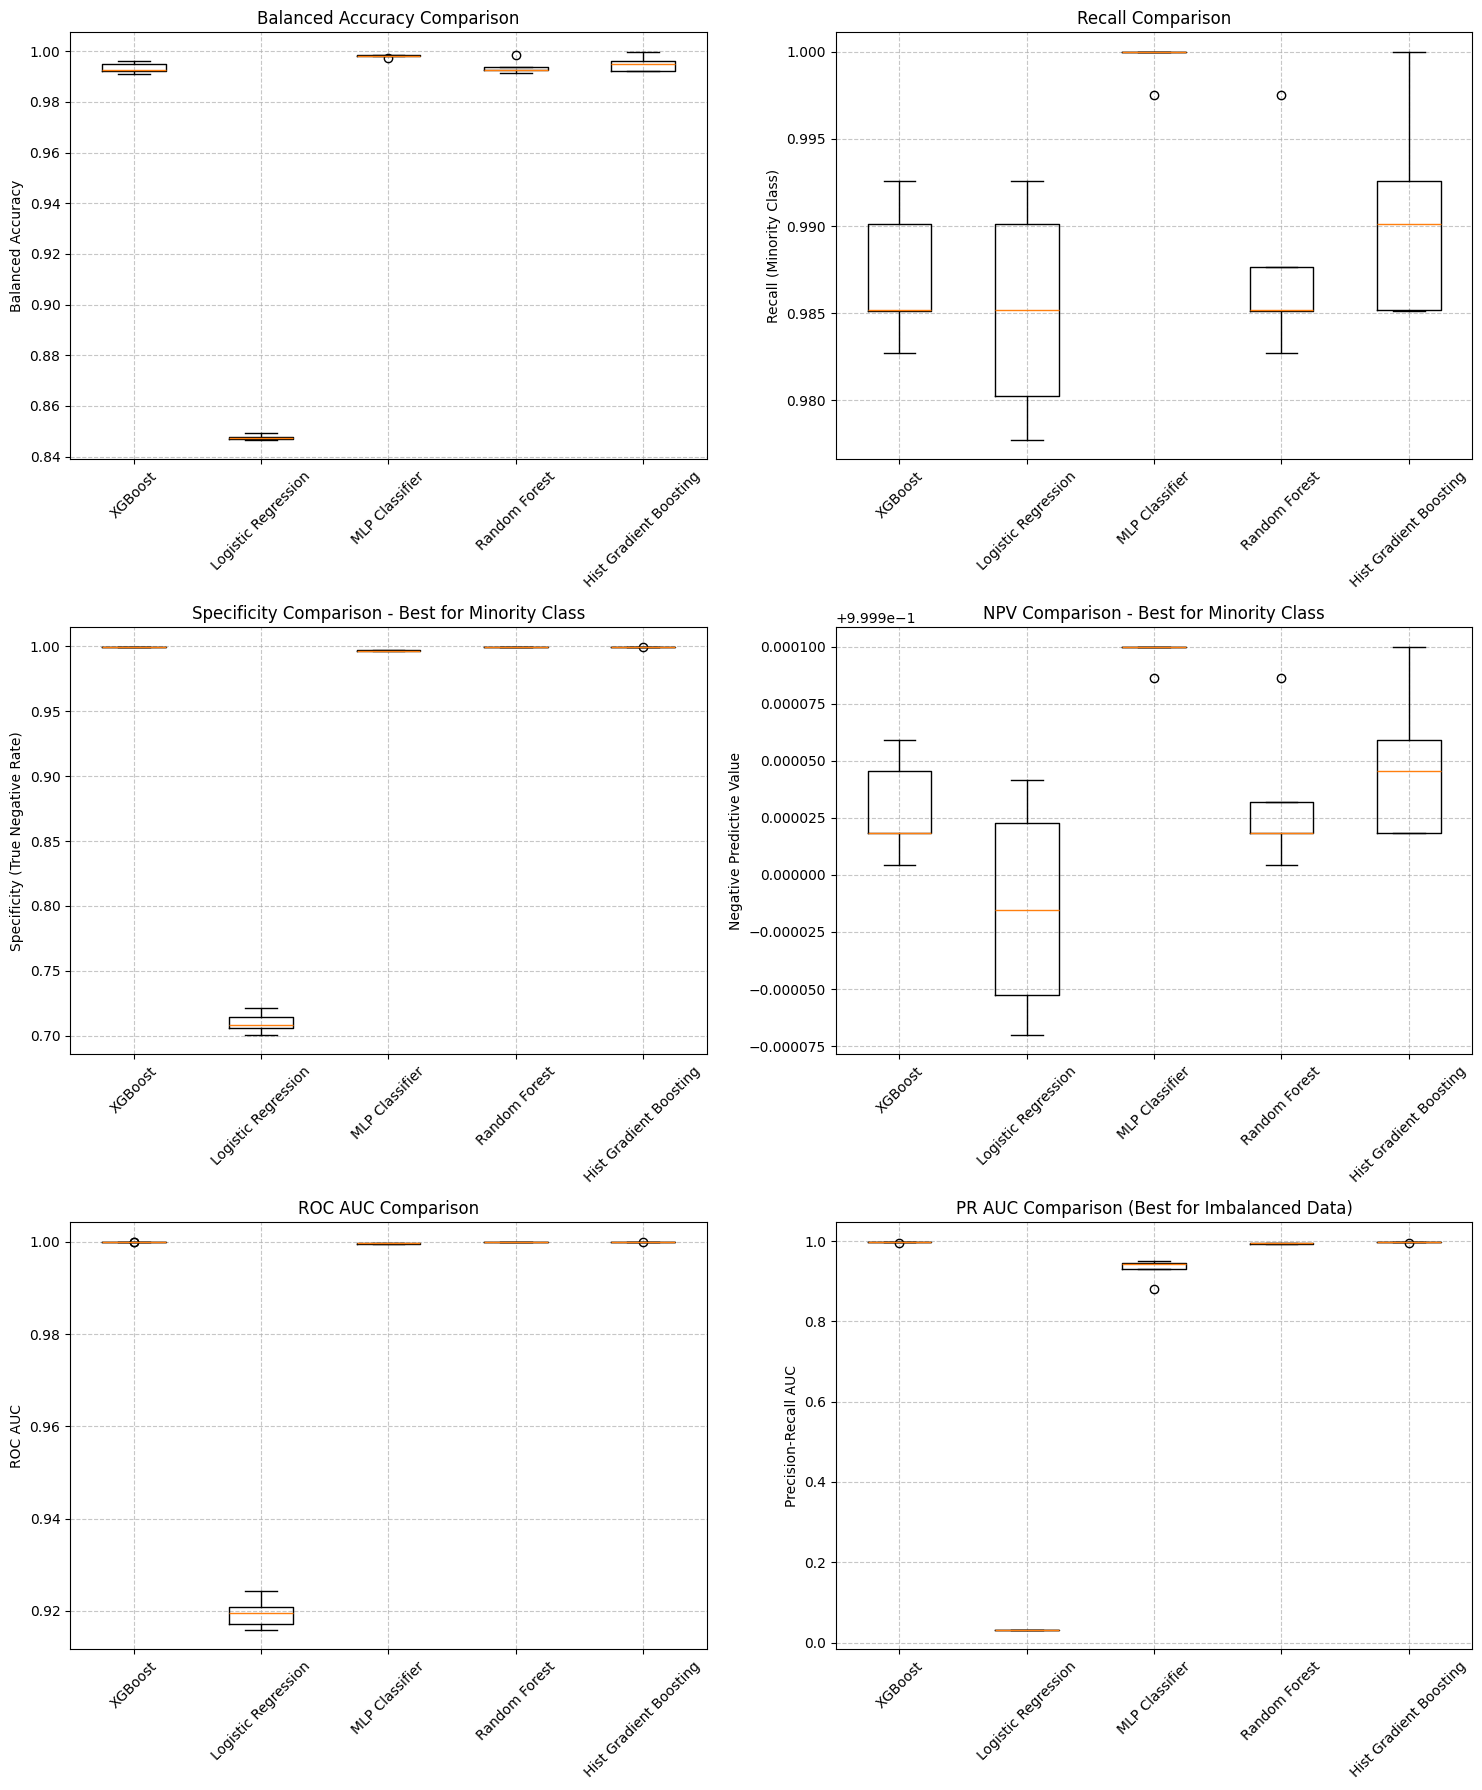

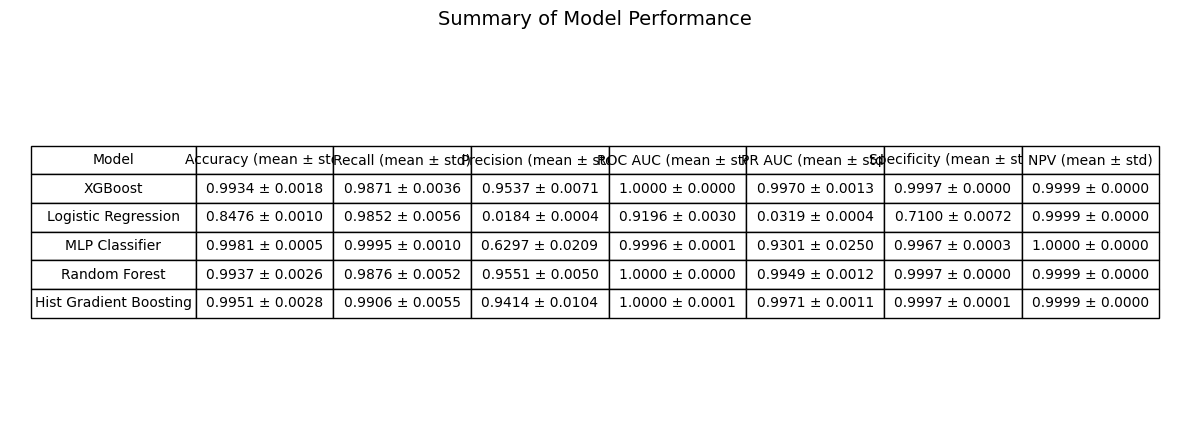


===== Summary of Model Performance =====
Model	Accuracy (mean ± std)	Recall (mean ± std)	Precision (mean ± std)	ROC AUC (mean ± std)	PR AUC (mean ± std)	Specificity (mean ± std)	NPV (mean ± std)
---------------------------------------------------------------------------------------------------------------------------------------------------------
XGBoost	0.9934 ± 0.0018	0.9871 ± 0.0036	0.9537 ± 0.0071	1.0000 ± 0.0000	0.9970 ± 0.0013	0.9997 ± 0.0000	0.9999 ± 0.0000
Logistic Regression	0.8476 ± 0.0010	0.9852 ± 0.0056	0.0184 ± 0.0004	0.9196 ± 0.0030	0.0319 ± 0.0004	0.7100 ± 0.0072	0.9999 ± 0.0000
MLP Classifier	0.9981 ± 0.0005	0.9995 ± 0.0010	0.6297 ± 0.0209	0.9996 ± 0.0001	0.9301 ± 0.0250	0.9967 ± 0.0003	1.0000 ± 0.0000
Random Forest	0.9937 ± 0.0026	0.9876 ± 0.0052	0.9551 ± 0.0050	1.0000 ± 0.0000	0.9949 ± 0.0012	0.9997 ± 0.0000	0.9999 ± 0.0000
Hist Gradient Boosting	0.9951 ± 0.0028	0.9906 ± 0.0055	0.9414 ± 0.0104	1.0000 ± 0.0001	0.9971 ± 0.0011	0.9997 ± 0.0001	0.9999 ± 0.0000


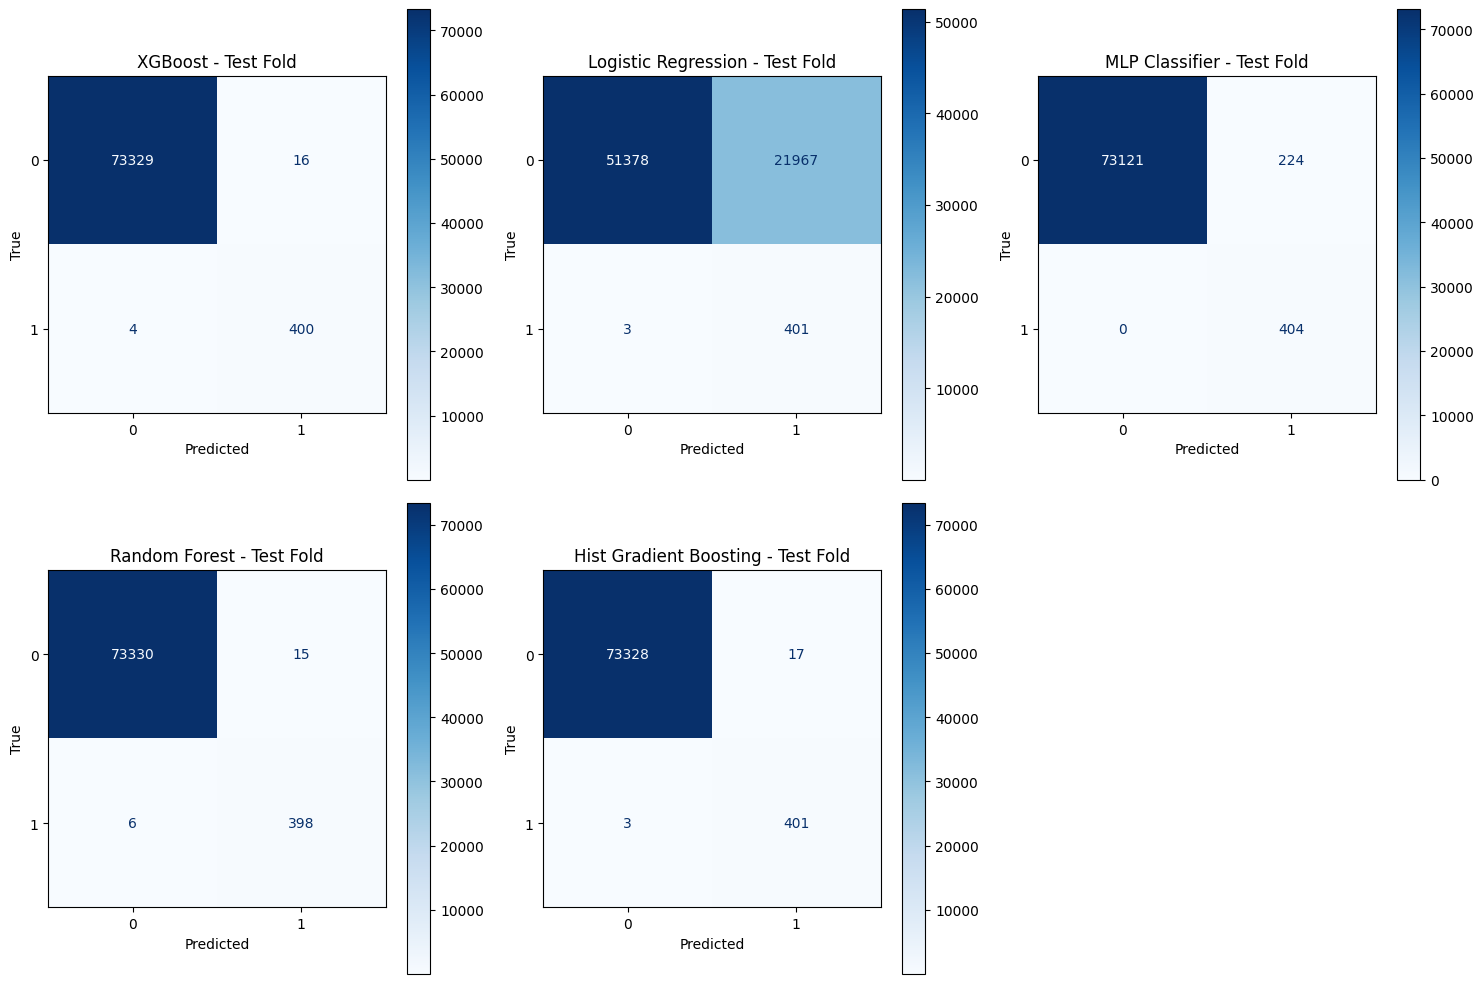

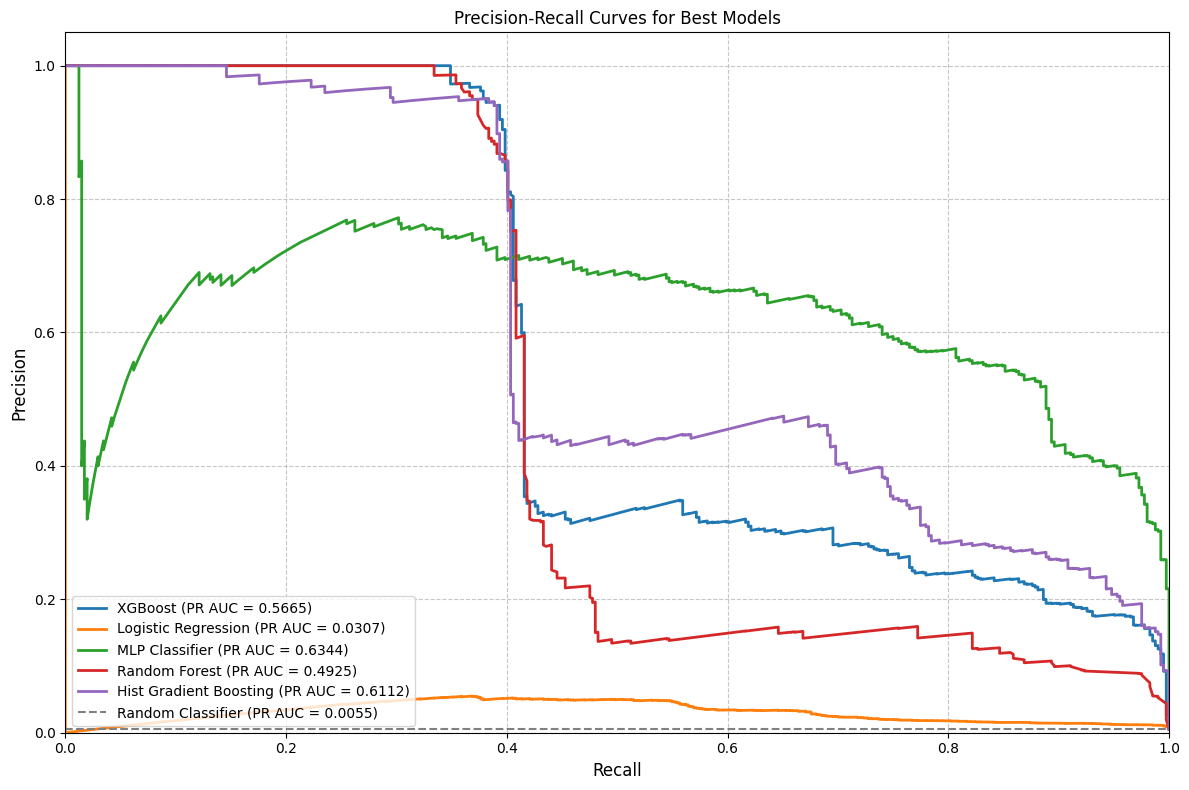

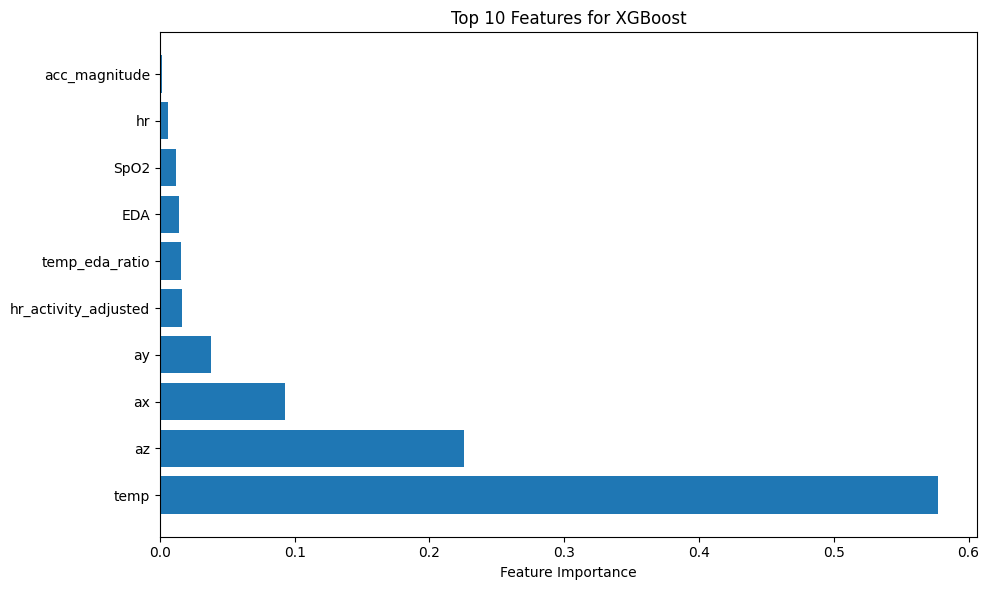

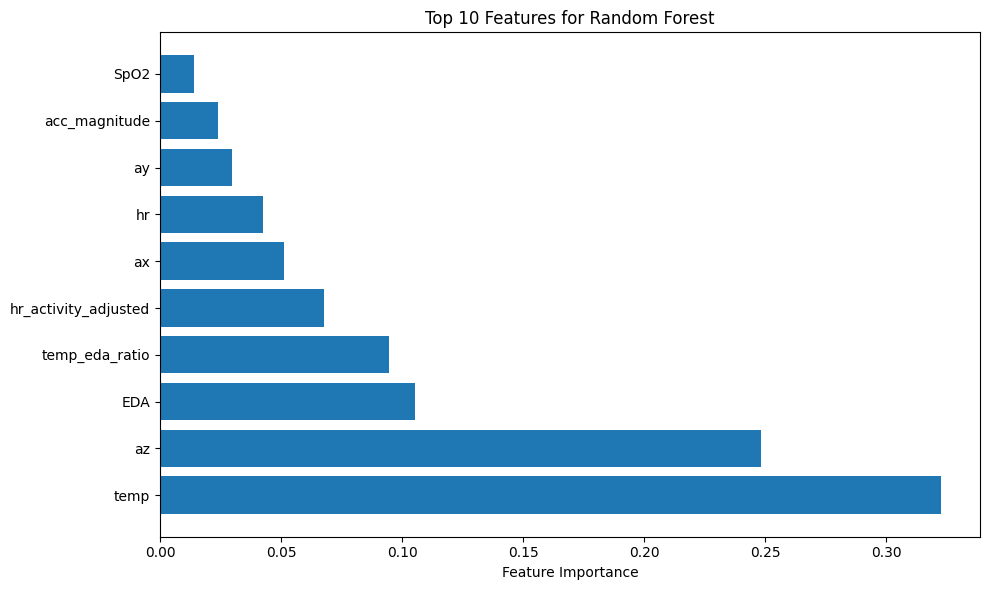

Best model (MLP Classifier)
Mean accuracy: 0.9981


In [19]:

if __name__ == "__main__":
    # Load data
    X = all_subjects_df.drop(columns=['physiological_stress', 'time', 'subject_id'])
    y = all_subjects_df['physiological_stress']
    
    # Run comparative analysis code
    results = run_comparative_analysis(X, y, random_seed=42, use_smote=True, use_weights=False, tune_hyperparams=True)
    
    # Plot feature importance
    importance_data = plot_feature_importance(results, top_n=10)
    
    # Save best model
    best_model_name, best_model = save_best_model(results)
